# Lab 3.1: **Learning Fast Approximations of Sparse Coding**
Welcome to COMSM0159 Advanced Visual AI (AVAI)!

The goal of this labsheet is to illustrate how to construct a very
fast algorithm that produces approximate estimates of the sparse code that can be used to compute good visual features.

In this class, you will learn

1. The basic structure of Time-Unfolded ISTA and how to deploy it on torch

2. Construct the manually defined dataset for training and testing.

In [23]:
## Importing necessary libraries
import torch as tor
import torch.nn as nn
import torch.utils.data
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import math

from sklearn.datasets import make_sparse_coded_signal

**The operations in below black box construct the basis of ISTA network.**

Y is the input. We, S and theta are the paramters, which needs learning.

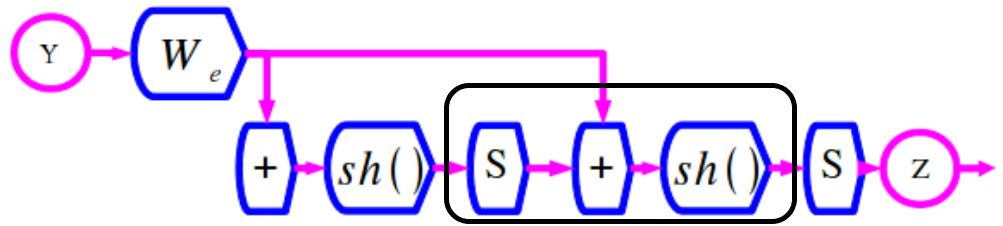

In [24]:
class listaUnit(nn.Module):

    """
        The basic unit of the lista network
    """

    def __init__(self,activation):

        super().__init__()

        self.activation = activation

    def forward(self,inp,B,S,theta):

        C = B + torch.matmul(S,inp)
        Z = self.activation(C,theta)

        return Z

In [25]:
class LISTAUnit(nn.Module):
    """
    Single LISTA Unit: Applies one iteration of the LISTA process
    """
    def __init__(self, activation_fn):
        super().__init__()
        self.activation_fn = activation_fn

    def forward(self, previous_output, linear_output, W_t, theta):
        """
        Forward pass through one LISTA unit
        """
        # Compute the current state: Add linear transformation and transition term
        current_state = linear_output + tor.matmul(W_t, previous_output)

        # Apply activation to generate the sparse code
        sparse_output = self.activation_fn(current_state, theta)

        return sparse_output


**The Whole network structure defined in torch**

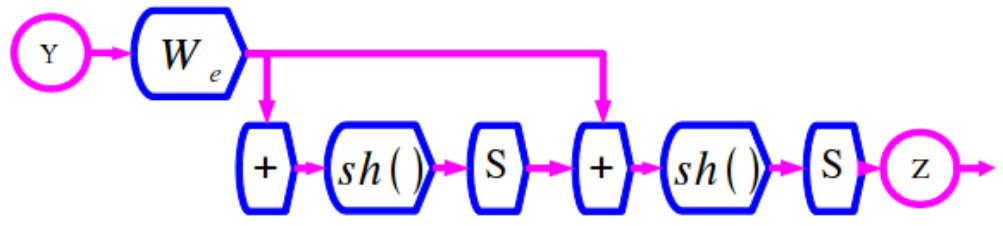

In [26]:
class listanet(nn.Module):

    """
        This is the lista network, that takes as input a signal vector and outputs a sparse code
    """

    def __init__(self,activation,n_features,n_components,device):

        super().__init__()

        self.n = n_features
        self.m = n_components

        self.activation = activation

        ## defining learnable parameters
        self.We = nn.Parameter(tor.rand(self.m, self.n).to(device) * 0.001, requires_grad = True)
        self.S = nn.Parameter(tor.rand(self.m, self.m).to(device) * 0.001, requires_grad = True)    # S refers to the W_t
        self.theta = nn.Parameter(tor.rand(self.m, 1).to(device) * 0.001, requires_grad = True)

        self.l1 = listaUnit(self.activation)
        self.l2 = listaUnit(self.activation)
        self.l3 = listaUnit(self.activation)

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.We,a = math.sqrt(5))
        nn.init.kaiming_uniform_(self.S,a = math.sqrt(5))
        nn.init.uniform_(self.theta,-0.001,0.001)

    def forward(self,x):

        B =  tor.matmul(self.We,x)

        Z0 = self.activation(B,self.theta)

        Z1 = self.l1(Z0,B, self.S, self.theta)
        Z2 = self.l2(Z1,B, self.S, self.theta)
        Z3 = self.l3(Z2,B, self.S, self.theta)

        return Z3

In [27]:
class LISTANet(nn.Module):
    """
    LISTA Network: Takes a signal vector and outputs a sparse code
    """
    def __init__(self, activation_fn, input_size, output_size, device):
        super().__init__()

        # Network dimensions
        self.input_size = input_size  # Number of features in input signal
        self.output_size = output_size  # Number of components in sparse code

        # Activation function (e.g., soft-thresholding)
        self.activation_fn = activation_fn

        # Learnable parameters: weights and thresholds
        self.W_e = nn.Parameter(tor.rand(self.output_size, self.input_size).to(device) * 0.001, requires_grad=True)  # Encoder weights (W_e)
        self.W_t = nn.Parameter(tor.rand(self.output_size, self.output_size).to(device) * 0.001, requires_grad=True)  # Transition weights (W_t)
        self.theta = nn.Parameter(tor.rand(self.output_size, 1).to(device) * 0.001, requires_grad=True)  # Activation threshold

        # LISTA Units for iterative layers
        self.layer1 = LISTAUnit(self.activation_fn)
        self.layer2 = LISTAUnit(self.activation_fn)
        self.layer3 = LISTAUnit(self.activation_fn)

    def initialize_parameters(self):
        """
        Initialize network parameters for stable training
        """
        nn.init.kaiming_uniform_(self.W_e, a=math.sqrt(5))  # Initialize encoder weights
        nn.init.kaiming_uniform_(self.W_t, a=math.sqrt(5))  # Initialize transition weights
        nn.init.uniform_(self.theta, -0.001, 0.001)  # Initialize activation threshold with small values

    def forward(self, signal_input):
        """
        Forward pass through LISTA network
        """
        # Step 1: Linear transformation of input with W_e
        linear_output = tor.matmul(self.W_e, signal_input)

        # Step 2: Initial sparse representation with activation
        Z0 = self.activation_fn(linear_output, self.theta)

        # Step 3: Iterative refinement of sparse codes with W_t
        Z1 = self.layer1(Z0, linear_output, self.W_t, self.theta)
        Z2 = self.layer2(Z1, linear_output, self.W_t, self.theta)
        Z3 = self.layer3(Z2, linear_output, self.W_t, self.theta)

        return Z3  # Final output


**Task 1:** Firstly run all the kernels in this script to understand how the training process works. After that, try to use different activation function to see how it influences the training.
**Hint**: Function **soft_threshold** and **batch_soft_threshold** are two different activation functions.

Further exploration: Can you construct different activation functions for this network?

In [28]:
def soft_threshold(v,theta):

    """
        The soft-thresholding function
    """

    v = tor.sign(v) * tor.max(tor.abs(v) - theta,tor.tensor(0.0).to(device))

    return v

In [29]:
def batch_soft_threshold(v,theta):

    """
        perform soft-thresholding on the entire batch
    """
    batch_size,i,j = v.size()
    v1 = v.clone()

    for k in range(batch_size):

        v1[k,:,:] = soft_threshold(v[k,:,:],theta)

    return v1

**Generate random data for training**

In [30]:
def getdata(n_features,n_components,n_samples,n_nonzero_coefs,random_state = None,train_size = 0.8):

    """
        Obtain the data of signal, the corresponding dictionary and the sparse codes
    """
    X,Wd,Z = make_sparse_coded_signal(n_samples=n_samples,n_components=n_components,n_features=n_features,n_nonzero_coefs=n_nonzero_coefs, random_state=random_state)
    mid1 = int(X.shape[1] * (train_size))
    mid2 = mid1 + int(X.shape[1] * (1 - train_size))//2

    Xval = X[:mid1,:]
    Xtest = X[mid1:mid2,:]
    Xtrain = X[mid2:,:]
    Zval = Z[:mid1,:]
    Ztest = Z[mid1:mid2,:]
    Ztrain = Z[mid2:,:]

    Xtrain,Xtest,Ztrain,Ztest = tor.from_numpy(Xtrain).unsqueeze(-1).unsqueeze(-1),tor.from_numpy(Xtest).unsqueeze(-1).unsqueeze(-1),tor.from_numpy(Ztrain).unsqueeze(-1).unsqueeze(-1),tor.from_numpy(Ztest).unsqueeze(-1).unsqueeze(-1)
    Xval,Zval = tor.from_numpy(Xval).unsqueeze(-1).unsqueeze(-1),tor.from_numpy(Zval).unsqueeze(-1).unsqueeze(-1)

    return Xtrain,Xval,Xtest,Wd,Ztrain,Zval,Ztest

In [31]:
class dataset(torch.utils.data.Dataset):

    """
        Dataset class
    """

    def __init__(self, phase = "train"):

        super().__init__()

        if(phase == "train"):
            self.Z = Ztrain
            self.X = Xtrain
        elif(phase == "val"):
            self.X = Xval
            self.Z = Zval
        elif(phase == "test"):
            self.X = Xtest
            self.Z = Ztest


        self.data_size = self.X.size(0)

    def __len__(self):
        return self.data_size

    def __getitem__(self,idx):

        Zi = self.Z[idx,:].type(tor.FloatTensor)
        Xi = self.X[idx,:].type(tor.FloatTensor)

        return Zi,Xi

### Divide the dataset into train, validation and test sets

In [32]:
Xtrain,Xval,Xtest,Wd,Ztrain,Zval,Ztest = getdata(n_features=100,n_components=100,n_samples=5000,n_nonzero_coefs=60)

### Create the training set and validation set

In [33]:
trainset = dataset()
trainloader = tor.utils.data.DataLoader(trainset,batch_size = 128)

valset = dataset(phase = "val")
valloader = tor.utils.data.DataLoader(valset,batch_size = 128)

### Set up the network and device configuration

In [34]:
device = tor.device("cuda:0" if tor.cuda.is_available() else "cpu")
print("using: ",device)

# net = listanet(batch_soft_threshold,100,100,device)
net = LISTANet(batch_soft_threshold, 100, 100, device)
# criterion = nn.MSELoss()

using:  cuda:0


In [35]:
def train(net,epochs,lr,reg,dataloaders,reset,save = False):

    """
        Method that performs training given a models
    """

    if(reset):
        net.reset_parameters()
        print("/////////////////////// weights reset \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr = 1e-3,weight_decay = reg)

    trainloader,valloader = dataloaders

    epoch_losses = []

    # with tor.autograd.set_detect_anomaly(True):
    for epoch in range(epochs):

        batch_losses = []

        for batch_idx,(z,x) in enumerate(trainloader):

            z,x = z.to(device),x.to(device)

            #print(z.shape,x.shape)
            optimizer.zero_grad()
            z = z.squeeze(2)
            x = x.squeeze(2)
            out = net(x)
            loss = criterion(out,z)


            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        print("epoch: ",epoch,"epoch loss: ",np.mean(batch_losses))

        net.eval()

        with tor.no_grad():

            batch_losses = []
            for batch_idx,(z,x) in enumerate(valloader):
                z,x = z.to(device),x.to(device)

                z = z.squeeze(2)
                x = x.squeeze(2)

                out = net(x)

                loss = criterion(out,z)

                batch_losses.append(loss.item())

            print("val loss: ",np.mean(batch_losses))

        net.train()

        print("-------------------------------------------------------------------------------------")

        if(save):
            state = net.state_dict()
            tor.save(state,"./model_chk.pth.tar")
            print("******************** saving the model ****************************")
    return epoch_losses

**Play with the toy set**

In [36]:
epochs = 100
lr = 1.38 * 1e-6
dataloaders = [trainloader,valloader]
reset = False
weight_decay = 1e-5

loss = train(net=net,epochs=epochs,lr=lr,reg=weight_decay,dataloaders=dataloaders,reset=reset,save=False)

epoch:  0 epoch loss:  0.4707018664250007
val loss:  0.3559664189815521
-------------------------------------------------------------------------------------
epoch:  1 epoch loss:  0.30136969150641024
val loss:  0.25902411341667175
-------------------------------------------------------------------------------------
epoch:  2 epoch loss:  0.22969740896652907
val loss:  0.20884078741073608
-------------------------------------------------------------------------------------
epoch:  3 epoch loss:  0.18798984357943901
val loss:  0.1739508956670761
-------------------------------------------------------------------------------------
epoch:  4 epoch loss:  0.15956744169577575
val loss:  0.1502121537923813
-------------------------------------------------------------------------------------
epoch:  5 epoch loss:  0.1388122857763217
val loss:  0.13271954655647278
-------------------------------------------------------------------------------------
epoch:  6 epoch loss:  0.12198975987923451
va